### 从0搭建一个音乐推荐系统
* 数据集介绍
* 基于排行榜的推荐
* 基于协同过滤的推荐
* 基于矩阵分解的推荐
* 基于GBDT+LR预估的排序
* 结语

In [1]:
# 第三方库
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#### Part 1. 数据集介绍
* 我们的数据集
* 数据集预处理

我们的数据集是从网上的一个项目中获得的，这个项目由The Echonest和LABRosa一起完成。数据集主要是多年间外国音乐的量化特征，包含了百万用户对几十万首歌曲的播放记录（train_triplets.txt，2.9G）和这些歌曲的详细信息（triplets_metadata.db，700M）。

你可以从我的博客中直接获取这些数据。我的博客地址

用户的播放记录数据集train_triplets.txt格式是这样的：用户 歌曲 播放次数，其中用户和歌曲都匿名

歌曲的详细信息数据集triplets_metadata.db则包括歌曲的发布时间、作者、作者热度等

由于数据集很大，可以从.txt文件中选取200万条数据作为我们的数据集。

##### Step 1. 对.txt文件的处理
* 通过编码和转换数据类型降低数据内存
* 过滤掉播放量过低的用户

In [2]:
# 读取数据
data = pd.read_csv(r'D:\myfile\机器学习及推荐系统\24、python-机器学习-进阶实战\唐宇迪-机器学习-进阶实战-资料\13.音乐推荐系统实战\Python实现音乐推荐系统\train_triplets.txt', 
                   sep='\t', header=None, names=['user', 'song', 'play_count'], nrows=2000000)
data.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [3]:
# 查看数据内存信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
user          object
song          object
play_count    int64
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


可以看到，用户和歌曲已经被加过密，不过这并不妨碍我们做推荐。

查看数据集内存信息，为了方便后面快速运算，我们需要降低其内存大小。具体的，
* 我们对user和song进行labelencoder
* 将所有的数据类型转化为int32

In [4]:
# label编码
user_encoder = LabelEncoder()
data['user'] = user_encoder.fit_transform(data['user'].values)

song_encoder = LabelEncoder()
data['song'] = song_encoder.fit_transform(data['song'].values)


# 数据类型转换
data.astype({'user': 'int32', 'song': 'int32', 'play_count': 'int32'})

,user,song,play_count
0,29990,3209,1
1,29990,4702,1
2,29990,8475,2
3,29990,9707,1
4,29990,9717,1
...,...,...,...
1999995,14869,150910,2
1999996,14869,152803,1
1999997,14869,163072,2
1999998,14869,171650,1


In [5]:
# 当前内存结果
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
user          int32
song          int32
play_count    int64
dtypes: int32(2), int64(1)
memory usage: 30.5 MB


这里，我们看到，内存从450M降低到300M，这样处理是有效的。

接着，我们需要进行一些基本的数据过滤。我们先来看一下用户的歌曲播放总量的分布情况。

In [6]:
# 用户的歌曲播放总量的分布
# 字典user_playcounts记录每个用户的播放总量
user_playcounts = {}
for user, group in data.groupby('user'):
    user_playcounts[user] = group['play_count'].sum()

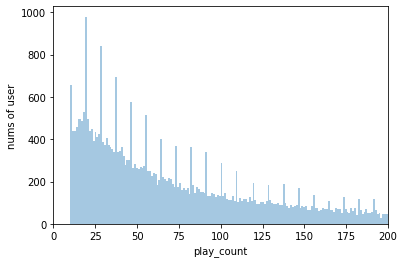

In [7]:
# 作图
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

从上图可以看到，有一大部分用户的歌曲播放量少于100。
少于100的歌曲播放量在持续几年的时间长度上来看是不正常的。
造成这种现象的原因，可能是这些用户不喜欢听歌，只是偶尔点开。
对于这些用户，我们看看他们在总体数据上的占比情况。

In [8]:
temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 100]
temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 100]

print('歌曲播放量大于100的用户数量占总体用户数量的比例为', str(round(len(temp_user)/len(user_playcounts), 4)*100)+'%')
print('歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(user_playcounts.values())*100, 4))+'%')
print('歌曲播放量大于100的用户产生的数据占总体数据的比例为', str(round(len(data[data.user.isin(temp_user)])/len(data)*100, 4))+"%")

歌曲播放量大于100的用户数量占总体用户数量的比例为 39.51%
歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为 80.278%
歌曲播放量大于100的用户产生的数据占总体数据的比例为 71.26%


通过上面的结果，我们可以看到，歌曲播放量大于100的用户占总体的40%，而正是这40%的用户，产生了80%的播放量，占据了总体数据的70%。
因此，我们可以直接将歌曲播放量少于100的用户过滤掉，而不影响整体数据。

In [9]:
# 过滤掉歌曲播放量少于100的用户的数据
data = data[data.user.isin(temp_user)]

类似的，我们挑选出具有一定播放量的歌曲。因为播放量太低的歌曲不但会增加计算复杂度，还会降低协同过滤的准确度。
我们首先看不同歌曲的播放量分布情况。

In [10]:
# song_playcounts字典，记录每首歌的播放量
song_playcounts = {}
for song, group in data.groupby('song'):
    song_playcounts[song] = group['play_count'].sum() 

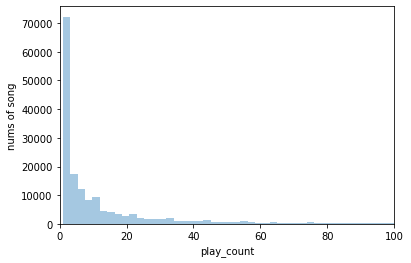

In [11]:
# 作图
sns.distplot(list(song_playcounts.values()), bins=10000, kde=False)
plt.xlim(0, 100)
plt.xlabel('play_count')
plt.ylabel('nums of song')
plt.show()

我们观察到，大部分歌曲的播放量非常少，甚至不到50次！这些歌曲完全无人问津，属于我们可以过滤掉的对象。

In [12]:
temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]

print('播放量大于20的歌曲数量占总体歌曲数量的比例为', str(round(len(temp_song)/len(song_playcounts), 4)*100)+'%')
print('播放量大于20的歌曲产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(song_playcounts.values())*100, 4))+'%')
print('播放量大于20的歌曲产生的数据占总体数据的比例为', str(round(len(data[data.song.isin(temp_song)])/len(data)*100, 4))+"%")

播放量大于20的歌曲数量占总体歌曲数量的比例为 10.2%
播放量大于20的歌曲产生的播放总量占总体播放总量的比例为 71.0557%
播放量大于20的歌曲产生的数据占总体数据的比例为 61.2672%


可以看到，播放量大于50的歌曲数量，占总体数量的27%，而这27%的歌曲，产生的播放总量和数据总量都占90%以上！
因此可以说，过滤掉这些播放量小于50的歌曲，对总体数据不会产生太大影响。

In [13]:
# 过滤掉播放量小于50的歌曲
data = data[data.song.isin(temp_song)]

##### Step 2. 对.db文件的处理
* 读取数据
* 对song_id进行labelencoder
* 将新读取的数据与原有data，按照song_id合并

In [14]:
# 读取数据
conn = sqlite3.connect(r'D:\myfile\机器学习及推荐系统\24、python-机器学习-进阶实战\唐宇迪-机器学习-进阶实战-资料\13.音乐推荐系统实战\Python实现音乐推荐系统\track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

# 获得数据的dataframe
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')

In [15]:
# 对于之前的歌曲编码，我们给一个字典，对歌曲和编码进行一一映射
song_labels = dict(zip(song_encoder.classes_, range(len(song_encoder.classes_))))

# 对于那些在之前没有出现过的歌曲，我们直接给一个最大的编码
encoder = lambda x: song_labels[x] if x in song_labels.keys() else len(song_labels)

# 对数据进行labelencoder
track_metadata_df['song_id'] = track_metadata_df['song_id'].apply(encoder)

In [16]:
# 对song_id重命名为song
track_metadata_df = track_metadata_df.rename(columns={'song_id': 'song'})

In [17]:
# 根据特征song进行拼接，将拼接后的数据重新命名为data
data = pd.merge(data, track_metadata_df, on='song')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 16 columns):
user                  907134 non-null int32
song                  907134 non-null int32
play_count            907134 non-null int64
track_id              907134 non-null object
title                 907134 non-null object
release               907134 non-null object
artist_id             907134 non-null object
artist_mbid           907134 non-null object
artist_name           907134 non-null object
duration              907134 non-null float64
artist_familiarity    907134 non-null float64
artist_hotttnesss     907134 non-null float64
year                  907134 non-null int64
track_7digitalid      907134 non-null int64
shs_perf              907134 non-null int64
shs_work              907134 non-null int64
dtypes: float64(3), int32(2), int64(5), object(6)
memory usage: 110.7+ MB


In [19]:
data.columns

Index(['user', 'song', 'play_count', 'track_id', 'title', 'release',
       'artist_id', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work'],
      dtype='object')

为了降低内存，我们同样进行类型转换，
* 将int64转换成int32
* 将float64转换为float32

In [20]:
data = data.astype({'play_count': 'int32', 'duration': 'float32', 'artist_familiarity': 'float32',
            'artist_hotttnesss': 'float32', 'year': 'int32', 'track_7digitalid': 'int32'})
print(' ')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 16 columns):
user                  907134 non-null int32
song                  907134 non-null int32
play_count            907134 non-null int32
track_id              907134 non-null object
title                 907134 non-null object
release               907134 non-null object
artist_id             907134 non-null object
artist_mbid           907134 non-null object
artist_name           907134 non-null object
duration              907134 non-null float32
artist_familiarity    907134 non-null float32
artist_hotttnesss     907134 non-null float32
year                  907134 non-null int32
track_7digitalid      907134 non-null int32
shs_perf              907134 non-null int64
shs_work              907134 non-null int64
dtypes: float32(3), int32(5), int64(2), object(6)
memory usage: 90.0+ MB


##### Step 3. 数据清洗
* 去重
* 丢掉无用信息

实际上，有些信息我们比较肯定是无用的，比如
* track_id
* artist_id
* artist_mbid
* duration
* track_7digitalid
* shs_perf
* shs_work

我们主要利用评分矩阵进行召回和排序，上面的信息我们应该用不到。

In [22]:
# 去重
data.drop_duplicates(inplace=True)
# 丢掉无用信息
data.drop(['track_id', 'artist_id', 'artist_mbid', 'duration', 'track_7digitalid', 'shs_perf', 'shs_work'], axis=1, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907134 entries, 0 to 907133
Data columns (total 9 columns):
user                  907134 non-null int32
song                  907134 non-null int32
play_count            907134 non-null int32
title                 907134 non-null object
release               907134 non-null object
artist_name           907134 non-null object
artist_familiarity    907134 non-null float32
artist_hotttnesss     907134 non-null float32
year                  907134 non-null int32
dtypes: float32(2), int32(4), object(3)
memory usage: 48.4+ MB


##### Step 4. 可视化

这里，我们利用词云，直观看一下最受欢迎的歌手、专辑和歌曲。

In [24]:
data.head()

,user,song,play_count,title,release,artist_name,artist_familiarity,artist_hotttnesss,year
0,29990,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
1,20160,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
2,19083,3209,3,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
3,5860,3209,1,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0
4,10262,3209,6,The Cove,Thicker Than Water,Jack Johnson,0.832012,0.677482,0


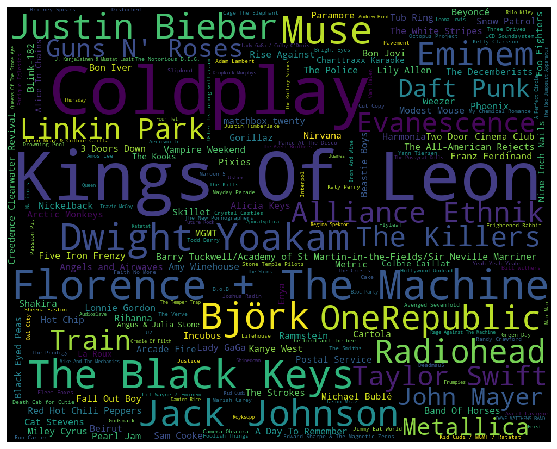

In [25]:
# 字典artist_playcounts记录每个歌手获得的点击量
artist_playcounts = {}
for artist, group in data.groupby('artist_name'):
    artist_playcounts[artist] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(artist_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

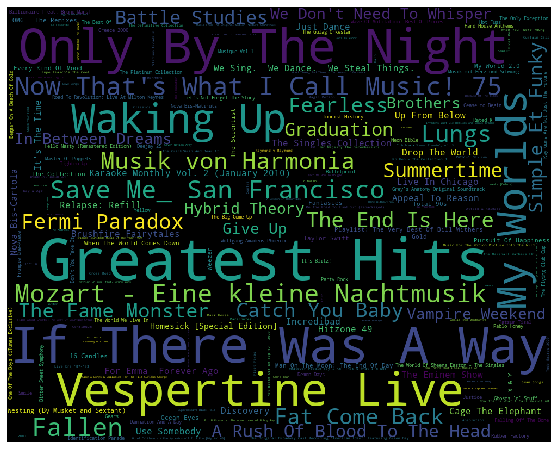

In [26]:
# 字典release_playcounts记录每个专辑获得的点击量
release_playcounts = {}
for release, group in data.groupby('release'):
    release_playcounts[release] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(release_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

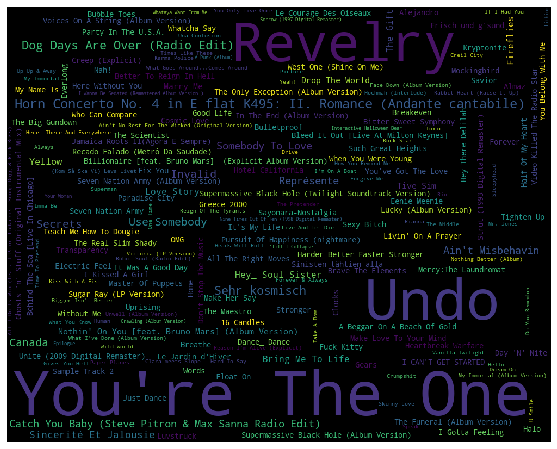

In [27]:
# 字典song_playcounts记录每首歌获得的点击量
song_playcounts = {}
for song, group in data.groupby('title'):
    song_playcounts[song] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(song_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

#### Part 2. 不同的推荐引擎

对于系统的召回阶段，我们将给出如下三种推荐方式，分别是
* 基于排行榜的推荐
* 基于协同过滤的推荐
* 基于矩阵分解的推荐

##### Step 1. 基于排行榜的推荐
我们将每首歌听过的人数作为每首歌的打分。
这里之所以不将点击量作为打分，是因为一个人可能对一首歌多次点击，但这首歌其他人并不喜欢。

In [28]:
# 基于排行榜的推荐
def recommendation_basedonPopularity(df, N=5):
    my_df = df.copy()
    # 字典song_peopleplay，记录每首歌听过的人数
    song_peopleplay = {}
    for song, group in my_df.groupby('title'):
        song_peopleplay[song] = group['user'].count()
    
    # 根据人数从大到小排序，并推荐前N首歌
    sorted_dict = sorted(song_peopleplay.items(), key=lambda x: x[1], reverse=True)[:N]
    # 取出歌曲
    return list(dict(sorted_dict).keys())

# 测试推荐结果
recommendation_basedonPopularity(data, N=5)

['Use Somebody',
 'Sehr kosmisch',
 'Dog Days Are Over (Radio Edit)',
 'Yellow',
 'Undo']

##### Step 2. 基于协同过滤的推荐
协同过滤需要用户-物品评分矩阵。
这里，用户对某首歌的评分的计算公式如下，
* 该用户的最大歌曲点击量
* 当前歌曲点击量/最大歌曲点击量
* 评分为log(2 + 上述比值)

得到用户-物品评分矩阵之后，我们用surprise库中的knnbasic函数进行协同过滤。

In [29]:
(data['play_count'].min(), data['play_count'].max())

(1, 1890)

In [30]:
# 每个用户点击量的平均数
user_averageScore = {}
for user, group in data.groupby('user'):
    user_averageScore[user] = group['play_count'].mean()

In [31]:
data['rating'] = data.apply(lambda x: np.log(2 + x.play_count / user_averageScore[x.user]), axis=1)

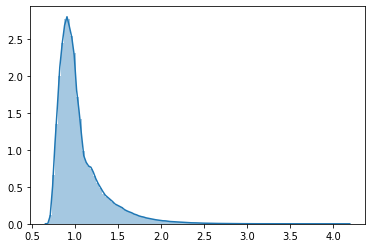

In [32]:
sns.distplot(data['rating'].values, bins=100)
plt.show()

In [33]:
# 得到用户-音乐评分矩阵
user_item_rating = data[['user', 'song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'song': 'item'})


首先，我们做itemCF的推荐。

In [34]:
# itemCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
knn_itemcf = KNNBasic(k=40, sim_options={'user_based': False})
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    knn_itemcf.fit(trainset)
    predictions = knn_itemcf.test(testset)
    accuracy.rmse(predictions, verbose=True)
  

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2771
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2755
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2759
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2762
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2764


In [35]:
#用户听过的歌曲集合
user_songs = {}
for user, group in user_item_rating.groupby('user'):
    user_songs[user] = group['item'].values.tolist()

# 歌曲集合
songs = user_item_rating['item'].unique().tolist()

# 歌曲id和歌曲名称对应关系
songID_titles = {}
for index in data.index:
    songID_titles[data.loc[index, 'song']] = data.loc[index, 'title']   

In [36]:
user_item_rating.head()

,user,item,rating
0,29990,3209,0.969401
1,20160,3209,0.937644
2,19083,3209,1.018099
3,5860,3209,0.871477
4,10262,3209,1.188672


In [37]:
# itemCF 推荐
def recommendation_basedonItemCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_itemcf.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = [songID_titles[s] for s in song_ids.keys()]
    
    return song_topN

recommendation_basedonItemCF(29990)

['Harmour Love',
 'Third Rate Romance',
 "I'm Made Of Wax_ Larry_ What Are You Made Of? [Live In Switzerland]",
 'Hold On',
 'Transit (Original)']

其次，我们做userCF的推荐。

In [38]:
# userCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
knn_usercf = KNNBasic(k=40, sim_options={'user_based': True})
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    knn_usercf.fit(trainset)
    predictions = knn_usercf.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2736
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2727
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2726
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2718
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2728


In [39]:
# userCF 推荐
def recommendation_basedonUserCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = [songID_titles[s] for s in song_ids.keys()]
    
    return song_topN

recommendation_basedonUserCF(29990)

['Thais II',
 'In the Summertime',
 'A Whiter Shade Of Pale',
 'Point Of No Return (1995 Digital Remaster)',
 'Imaginary Music (Album Version)']

##### Step 3. 基于矩阵分解的推荐
矩阵分解同样需要用户-物品评分矩阵。
我们依然沿用上面的评分矩阵进行预测。
同样的，我们用surprise库里面的SVD来进行矩阵分解方法。

In [40]:
# 矩阵分解（SVD）

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
algo = SVD(n_factors=40, biased=True)
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.2752
RMSE: 0.2753
RMSE: 0.2754
RMSE: 0.2737
RMSE: 0.2744


In [41]:
# 矩阵分解 推荐
def recommendation_basedonMF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = algo.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = song_ids
    
    return song_topN

recommendation_basedonMF(29990)

{81355: 1.5982666259368534,
 95737: 1.5757554349607223,
 8295: 1.5418165316960677,
 164248: 1.5306167647485174,
 46756: 1.5236919712185368}

#### Part 3. 推荐系统的排序

对于系统的排序阶段，我们通常是这样的，
* 以召回阶段的输出作为输入
* 用CTR预估作为进一步的排序标准

这里，我们可以召回50首音乐，用GBDT+LR对这些音乐做ctr预估，给出评分排序，选出5首歌曲。

现在，仅仅用用户-物品评分是不够的，因为我们需要考虑特征之间的组合。为此，我们用之前的data数据。

这里的数据处理思路是，
* 复制一份新的数据，命名为new_data
* 去掉title列，因为它不需要参与特征组合
* 对其余object列进行labelencoder编码
* **根据rating列数值情况，为了样本的正负均衡，我们令rating小于0.7的为0，也就是不喜欢，令rating大于0.7的为1，也就是喜欢**
* 将new_data按照0.5的比例分成两份，一份给gbdt作为训练集，一份给lr作为训练集

In [42]:
# 复制原data数据
rank_data = data.copy()
# 去掉无用的title列
rank_data.drop('title', axis=1, inplace=True)

# 将object类型数据用labelencoder编码
release_encoder = LabelEncoder()
rank_data['release'] = release_encoder.fit_transform(rank_data['release'].values)

artist_name_encoder = LabelEncoder()
rank_data['artist_name'] = artist_name_encoder.fit_transform(rank_data['artist_name'].values)

# 根据rating的取值，更新rating值
rank_data['rating'] = rank_data['rating'].apply(lambda x: 0 if x < 0.7 else 1)

rank_data.head()

,user,song,play_count,release,artist_name,artist_familiarity,artist_hotttnesss,year,rating
0,29990,3209,1,8740,2556,0.832012,0.677482,0,1
1,20160,3209,1,8740,2556,0.832012,0.677482,0,1
2,19083,3209,3,8740,2556,0.832012,0.677482,0,1
3,5860,3209,1,8740,2556,0.832012,0.677482,0,1
4,10262,3209,6,8740,2556,0.832012,0.677482,0,1


###### Step 1. GBDT+LR预估
这里，我们做一个ctr点击预估，将点击概率作为权重，与rating结合，作为最终的评分。
为了做这个，我们需要
* 分割数据集，一部分作为GBDT的训练集，一部分作为LR的训练集
* 先训练GBDT，将其结果作为输入，送进LR里面，再生成结果
* 最后看AUC指标

为了加快训练速度，我们从new_data的90多万条数据中，取出20万条作为训练数据。

In [43]:
# 取出20%的数据作为数据集
small_data = rank_data.sample(frac=0.2)
# 将数据集分成gbdt训练街和lr训练集
X_gbdt, X_lr, y_gbdt, y_lr = train_test_split(small_data.iloc[:, :-1].values, small_data.iloc[:, -1].values, test_size=0.5)

In [44]:
depth = 3
n_estimator = 50

print('当前n_estimators=', n_estimator)
# 训练gbdt
gbdt = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_split=3, min_samples_leaf=2)
gbdt.fit(X_gbdt, y_gbdt)

print('当前gbdt训练完成！')

# one-hot编码
onehot = OneHotEncoder()
onehot.fit(gbdt.apply(X_gbdt).reshape(-1, n_estimator))

# 对gbdt结果进行one-hot编码，然后训练lr
lr = LogisticRegression()
lr.fit(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)), y_lr)

print('当前lr训练完成！')

# 用auc作为指标
lr_pred = lr.predict(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)))
auc_score = roc_auc_score(y_lr, lr_pred)

print('当前n_estimators和auc分别为', n_estimator, auc_score)
print('#'*40)

当前n_estimators= 50
当前gbdt训练完成！
当前lr训练完成！
当前n_estimators和auc分别为 50 0.5
########################################


###### Step 2. 排序
这里，我们通过svd召回50首歌，然后根据gbdt+lr的结果做权重，给它们做排序，选出其中的5首歌作为推荐结果。

In [45]:
# 推荐
def recommendation(userID):
    # 召回50首歌
    recall = recommendation_basedonMF(userID, 50)
    #print(recall)
    
    print('召回完毕！')
    
    # 根据召回的歌曲信息，写出特征向量
    feature_lines = []
    for song in recall.keys():
        feature = rank_data[rank_data.song==song].values[0]
        # 出去其中的rating，将user数值改成当前userID
        feature = feature[:-1]
        feature[0] = userID
        # 放入特征向量中
        feature_lines.append(feature)
    
    # 用gbdt+lr计算权重
    weights = lr.predict_proba(onehot.transform(gbdt.apply(feature_lines).reshape(-1, n_estimator)))[:, 1]
    
    #print(weights.shape)
    print('排序权重计算完毕！')
    
    # 计算最终得分
    score = {}
    i = 0
    for song in recall.keys():
        score[song] = recall[song] * weights[i]
        i += 1
    
    #print(score)
    
    # 选出排名前5的歌曲id
    song_ids = dict(sorted(score.items(), key=lambda x: x[1], reverse=True)[: 5])
    # 前5歌曲名称
    song_topN = [songID_titles[s] for s in song_ids.keys()]
    
    print('最终推荐列表为')
    
    return song_topN

# 测试
recommendation(29990)

召回完毕！
(50,)
排序权重计算完毕！
最终推荐列表为


['Sheena Is A Punk Rocker',
 'Voodoo (live)',
 'The Nutcracker - Suite Op. 71a (2007 Digital Remaster): I.    Miniature Overture',
 'In League With Satan',
 'Bros Sto Rimagmeno Spiti (2003 Digital Remaster)']

In [46]:
# data[rank_data.user==29990]['title']